In [1]:
%matplotlib inline
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi


In [2]:
df = load_rossi()
cph = CoxPHFitter().fit(df, 'week', 'arrest')

In [3]:
from lifelines.statistics import proportional_hazard_test
proportional_hazard_test(cph, df).print_summary()

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1

---
      test_statistic      p  -log2(p)
age            11.09 <0.005     10.17
fin             0.02   0.90      0.16
mar             0.67   0.41      1.27
paro            0.14   0.71      0.49
prio            0.02   0.88      0.18
race            1.46   0.23      2.14
wexp            7.18   0.01      7.08


#### Non-linear relationships

In [4]:
from zepid.base import create_spline_transform

In [5]:
cph = CoxPHFitter().fit(rossi[['week', 'arrest', 'age']], 'week', 'arrest')
cph.print_summary(model="no splines")

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -667.75
  time fit was run = 2019-03-29 14:22:32 UTC
             model = no splines


---
     coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
age -0.07      0.93      0.02 -3.50 <0.005     11.09       -0.11       -0.03
---
Concordance = 0.61
Log-likelihood ratio test = 15.27 on 1 df, -log2(p)=13.39


In [27]:
rossi_with_splines = rossi.copy()
spline_transform, bp = create_spline_transform(rossi_with_splines['age'], term=3, restricted=False)
rossi_with_splines[['age0', 'age1', 'age2']] = pd.DataFrame(spline_transform(rossi_with_splines['age']))
rossi_with_splines = rossi_with_splines.drop('age', axis=1)

In [28]:
cph = CoxPHFitter().fit(rossi_with_splines, 'week', 'arrest')
cph.print_summary(4, model="with restricted cubic splines")

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -660.1052
  time fit was run = 2019-03-29 14:43:54 UTC
             model = with restricted cubic splines


---
        coef exp(coef)  se(coef)       z      p  -log2(p)  lower 0.95  upper 0.95
fin  -0.4010    0.6697    0.1920 -2.0881 0.0368    4.7645     -0.7773     -0.0246
race  0.2841    1.3285    0.3081  0.9222 0.3564    1.4882     -0.3197      0.8879
wexp -0.2098    0.8107    0.2108 -0.9953 0.3196    1.6458     -0.6230      0.2034
mar  -0.4874    0.6142    0.3818 -1.2768 0.2017    2.3098     -1.2357      0.2608
paro -0.0680    0.9342    0.1954 -0.3481 0.7278    0.4585     -0.4510      0.3149
prio  0.0906    1.0949    0.0285  3.1790 0.0015    9.4021      0.0348      0.1465
age0 -0.0004    0.9996    0.0003 -1.1465 0.2516    1.9909     -0.0010      0.0003
age1  0.0006    1.0006    0.0007  0

In [8]:
cph.check_assumptions(rossi_with_splines)
proportional_hazard_test(cph, rossi_with_splines).print_summary()

Proportional hazard assumption looks okay.
<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1

---
      test_statistic    p  -log2(p)
age0            1.00 0.32      1.66
age1            0.38 0.54      0.90
fin             0.02 0.89      0.17
mar             0.35 0.56      0.85
paro            0.04 0.83      0.26
prio            0.07 0.80      0.32
race            1.73 0.19      2.41
wexp            4.90 0.03      5.22


In [9]:
age = np.arange(17, 45)
haz = (spline_transform(age) * cph.hazards_[['age0','age1']].values).sum(1)


In [10]:
haz

array([ 0.00000000e+00,  0.00000000e+00, -4.55508801e-04, -3.64407041e-03,
       -1.22987376e-02, -2.91525633e-02, -5.69386001e-02, -9.75718846e-02,
       -1.49695388e-01, -2.11134064e-01, -2.79712868e-01, -3.53256755e-01,
       -4.29590679e-01, -5.06539594e-01, -5.81928456e-01, -6.53582219e-01,
       -7.19325837e-01, -7.76984265e-01, -8.24382459e-01, -8.59345371e-01,
       -8.79697957e-01, -8.83265172e-01, -8.67871970e-01, -8.31705814e-01,
       -7.74404195e-01, -6.95967114e-01, -5.96394571e-01, -4.75686565e-01])

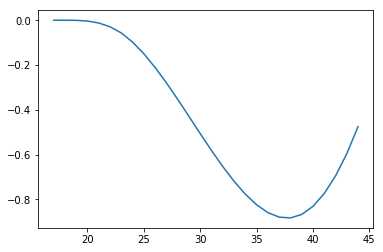

In [11]:
plot(age, haz)


In [15]:
rossi_with_quad = df.copy()
rossi_with_quad['age**2'] = (rossi_with_quad['age'] - rossi_with_quad['age'].mean()) ** 2
rossi_with_quad['age**3'] = (rossi_with_quad['age'] - rossi_with_quad['age'].mean()) ** 3

In [16]:
cph.fit(rossi_with_quad, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [17]:
cph.check_assumptions(rossi_with_quad)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines.

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
             test_statistic    p  -log2(p)
age    km              0.89 0.35      1.53
       rank            0.89 0.35      1.53
age**2 km              1.72 0.19      2.40
       rank            1.70 0.19      2.38
age**3 km              2.30 0.13      2.95
       rank            2.29 0.13      2.94
